##StateFarm Interest Rate Prediction-- Dingchao Zhang
###Summary
1. Two distinctive methods, one emsemble method: Gradient Boosting Regressor and one multi-variate linear regression method: Lasso Regularized Ordinary Linear Regression were selected to train and predict interest rate
2. Each Model building is executed in the following procedures: 
<br /> 
 Data Pre-processing/ Feature engineering: Cleaning, outliers examination and removal, predictors selection, datatype transformation, multi-collinearity removal, centering and scaling( if needed, e.g. Linear Regression Model)
<br />  
 Model Parameter tuning: cross validation and grid search is used to find the best parameter set that minimized RMSE
<br />  
 Model Evaluation and comparison: bootstrap sampling is used since it produces the smaller variance in model evaluation, and AIC/BIC is used to choose between Lasso and Ridge regression
3. Gradient Boosting does not needproduces lower RMSE than Lasso Regularized OLR, but slower to train
4. More discussions about pros and cons about the two models can be seen in the summary.pdf.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import decimal
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.svm import SVR

#data = pd.read_csv('data', parse_dates=[[0,1]], infer_datetime_format=True)
df = pd.read_csv("Data for Cleaning & Modeling.csv", infer_datetime_format=True,low_memory=False)

columnNames = ['int_rate','id_loan','id_borrower','loan_amt','funded_amt','funded_amt_inv',
              'term','grade','subgrade','emp_title','emp_length','home_ownership','annual_inc',
               'verification_status','issue_d','purpose','loan_cat','loan_title','zip_code',
               'state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_deliq',
               'mths_since_last_record','num_opencr_line','num_der_rec','revol_bal','revol_util',
               'total_cr_line','init_list_status']

df.columns = columnNames

# Pandas can not store NaN in int type column, thus had remove all NaNs from them as well
for col in ('loan_amt','funded_amt','funded_amt_inv', 'term'):
    df = df[pd.notnull(df[col])]
    
# reset index
df = df.reset_index(drop=True)

D = decimal.Decimal
# Pandas can not store NaN in int type column, thus had remove all NaNs
for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
    df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
    df[col] = df[col].astype('int')
    
#  Convert columns having % from obj(string type) to float and divide by 100    
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')/100

# Remove the rows where int_rate is missing
df = df[pd.notnull(df['int_rate'])]
# Reset index, this is critical
df = df.reset_index(drop=True)

df.drop(['id_loan','id_borrower'],1, inplace=True)

from datetime import datetime
# Read the column in the correct format
temp = pd.to_datetime(df['issue_d'],format = '%b-%d')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/1900', date_format)

d = np.zeros(len(temp))
for i in range(len(temp)):
    try:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'D').astype(int))/365)
        #break
    except:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'M').astype(int))/12)

df['issue_d'] = d

# Remove the rows where annual income claim is larger than 1 million
df = df[df['annual_inc'] <= 1000000]
# Reset index, this is critical
df = df.reset_index(drop=True)

df.drop(['emp_title'],1, inplace=True)

df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

df.drop(['purpose'],1, inplace=True)
df.drop(['loan_title'],1, inplace=True)
df.drop(['zip_code'],1, inplace=True)

from datetime import datetime
# Read the column in the correct format
t = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/2017', date_format)

d = np.zeros(len(t))
for i in range(len(t)):
    try:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
        #break
    except:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

d[d<0] = d[d<0] + 100

df['earliest_cr_line'] = d

df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

df.drop(['funded_amt','funded_amt_inv','mths_since_last_record', 'total_cr_line','subgrade'], axis=1, inplace=True)

cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

df.drop(['mths_since_last_deliq'], axis=1, inplace=True)



## STEP 1 Predictors Filtering and Pre-Processing
#### Preliminary data exploratory, dropping useless attributes and cleaning-up/ modifying others

Load the data and quickly review the first slice of data frame

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import decimal
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.svm import SVR

# Read the training.csv into data frame df
df = pd.read_csv("training.csv", infer_datetime_format=True,low_memory=False)

# Column names according to the Metadata.csv
columnNames = ['int_rate','id_loan','id_borrower','loan_amt','funded_amt','funded_amt_inv',
              'term','grade','subgrade','emp_title','emp_length','home_ownership','annual_inc',
               'verification_status','issue_d','purpose','loan_cat','loan_title','zip_code',
               'state','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','mths_since_last_deliq',
               'mths_since_last_record','num_opencr_line','num_der_rec','revol_bal','revol_util',
               'total_cr_line','init_list_status']

# Name the data frame with the columnNames
df.columns = columnNames

# Review the head of the data frame
df.head(3)

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,grade,subgrade,emp_title,...,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
0,11.89%,54734,80364,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,Feb-94,0,NaN,NaN,10,0,28854,52.10%,42,f
1,10.71%,55742,114426,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,Oct-00,0,NaN,NaN,7,0,33623,76.70%,7,f
2,16.99%,57167,137225,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,Jun-00,0,41,NaN,10,0,19878,66.30%,17,f


Review the data type of the first several columns

In [89]:
df.ix[:3,:7].dtypes

int_rate           object
id_loan           float64
id_borrower       float64
loan_amt           object
funded_amt         object
funded_amt_inv     object
term               object
dtype: object

### Convert data type column of int_rate, loan_amt,funded_amt, funded_amt_inv,term
1. int_rate, loan_amt,funded_amt, funded_amt_inv,term were loaded as object data type due to '%' or '$' or 'months' characters,thus need strip those characters out and convert column type
2. loan_amt,funded_amt, funded_amt_inv,term need to be converted to int type, and Pandas do not allow to store NaN in int column, thus will remove NaN from those columns before convert

In [90]:
# Pandas can not store NaN in int type column, thus had remove all NaNs from them as well
for col in ('loan_amt','funded_amt','funded_amt_inv', 'term'):
    df = df[pd.notnull(df[col])]
    
# reset index
df = df.reset_index(drop=True)

D = decimal.Decimal
# Pandas can not store NaN in int type column, thus had remove all NaNs
for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
    df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
    df[col] = df[col].astype('int')
    
#  Convert columns having % from obj(string type) to float and divide by 100    
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')/100

### Dealing missing values in int_rate column
1. There were some NaN value in int_rate column, we need to examine the pattern of missingness to understand if it can be
informative missingness, e.g.: certain loan requested by certain borrower were rejected thus no int_rate recorded
2. lf it is no informative missingness, then we can remove the rows in which the int_rate is missing

In [91]:
# Describe the columns where int_rate value is missing
df[pd.isnull(df['int_rate'])].describe()

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,total_cr_line
count,0,61010.000000,61010.00000,61010.000000,61010.000000,61010.000000,61010.000000,51734.000000,61010.000000,61010.000000,61010.000000,27665.000000,7755.000000,61010.000000,61010.000000,61010.000000,61010.000000
mean,NaN,10013043.130634,11366605.92852,14257.931077,14231.621865,14188.417128,42.463990,73208.373956,17.020475,0.275873,0.812949,34.236255,77.198968,11.117243,0.150041,15854.421898,25.009130
std,NaN,7923666.061475,8659546.18622,8246.996054,8230.712767,8227.999839,10.646804,54045.679519,7.742808,0.772163,1.055861,21.780102,28.666714,4.912408,0.450513,18154.455242,11.485004
min,NaN,68926.000000,92390.00000,1000.000000,1000.000000,300.000000,36.000000,4800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,NaN,3158950.500000,3769079.25000,8000.000000,8000.000000,8000.000000,36.000000,45000.000000,11.240000,0.000000,0.000000,16.000000,55.000000,8.000000,0.000000,6408.000000,17.000000
50%,NaN,8295077.500000,9677484.00000,12000.000000,12000.000000,12000.000000,36.000000,63000.000000,16.740000,0.000000,0.000000,31.000000,80.000000,10.000000,0.000000,11757.000000,23.000000
75%,NaN,15340539.250000,17332998.25000,20000.000000,20000.000000,19925.000000,60.000000,88500.000000,22.600000,0.000000,1.000000,49.000000,103.000000,14.000000,0.000000,20055.000000,32.000000
max,NaN,28753078.000000,31278000.00000,35000.000000,35000.000000,35000.000000,60.000000,6000000.000000,39.950000,15.000000,8.000000,152.000000,119.000000,53.000000,11.000000,1190046.000000,121.000000


3  We can see that the min funded amt is 1000 thus no loan request was not approved, also skipping through the min and max range of other columns, we can see that there is no particular pattern of int_rate missingness, therefore we can safely remove rows of missing int_rate

In [92]:
# Remove the rows where int_rate is missing
df = df[pd.notnull(df['int_rate'])]
# Reset index, this is critical
df = df.reset_index(drop=True)

### Understand the relationship between Loan amount requested vs funded amount
1. Let's discover the relationship between loan amount requested verus the funded amount see if a lower amount is issued and why.

In [93]:
print ("Loan amount requested not equal to funded amount:\n", (df['loan_amt'] != df['funded_amt']).value_counts())
print ("\nLoan amount requested smaller than funded amount:\n",(df['loan_amt'] > df['funded_amt']).value_counts())

Loan amount requested not equal to funded amount:
 False    337338
True       1651
dtype: int64

Loan amount requested smaller than funded amount:
 False    337338
True       1651
dtype: int64


2 There were 1651 instances where loan amt is not equal to funded amt and they were all funded amount lower than requested amount

In [94]:
df[(df['loan_amt'] > df['funded_amt'])].describe()

,int_rate,id_loan,id_borrower,loan_amt,funded_amt,funded_amt_inv,term,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,total_cr_line
count,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1651.000000,1445.000000,1651.000000,1651.000000,1651.000000,512.000000,91.000000,1651.000000,1651.000000,1651.000000,1651.000000
mean,0.123344,661620.138704,820854.021805,18861.901878,12976.877650,11955.199273,49.998789,83621.750325,13.741593,0.137492,0.874016,35.378906,86.780220,10.180497,0.050878,19336.230769,25.677771
std,0.044364,383445.320296,468243.822001,7989.809082,5936.465913,6621.371746,11.835949,110624.861410,6.707110,0.453798,1.080347,21.631430,33.849603,4.264882,0.225262,20005.724271,11.507378
min,0.054200,58915.000000,136922.000000,1500.000000,1000.000000,0.000000,36.000000,12000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000
25%,0.086300,522173.000000,675128.500000,12425.000000,8400.000000,7600.000000,36.000000,50000.000000,8.610000,0.000000,0.000000,18.000000,86.500000,7.000000,0.000000,6774.500000,17.000000
50%,0.116600,611554.000000,783538.000000,19000.000000,12650.000000,12075.000000,60.000000,70099.000000,14.240000,0.000000,1.000000,32.000000,99.000000,9.000000,0.000000,13815.000000,24.000000
75%,0.159500,784370.500000,987210.000000,25000.000000,16675.000000,16104.500000,60.000000,98000.000000,19.055000,0.000000,1.000000,50.250000,108.000000,13.000000,0.000000,24675.500000,33.000000
max,0.247000,7060671.000000,8647048.000000,35000.000000,34675.000000,34650.000000,60.000000,3900000.000000,31.410000,5.000000,8.000000,82.000000,118.000000,28.000000,2.000000,147897.000000,79.000000


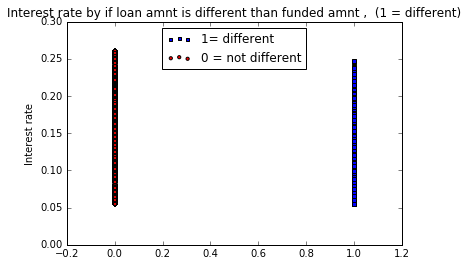

In [95]:
# Create a scatter plot to compare interest rate by if loan amnt is different than funded amnt or not
x1 = np.ones((len(df[(df['loan_amt'] != df['funded_amt'])]['int_rate']), 1))
y1 = df[(df['loan_amt'] != df['funded_amt'])]['int_rate']
x0 = np.zeros((len(df[(df['loan_amt'] == df['funded_amt'])]['int_rate']), 1))
y0 = df[(df['loan_amt'] == df['funded_amt'])]['int_rate']
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, s=10, c='b', marker="s",label = '1= different')
ax1.scatter(x0,y0, s=10, c='r', marker="o",label = '0 = not different')
plt.ylabel("Interest rate")
plt.legend(loc='upper center');
plt.title("Interest rate by if loan amnt is different than funded amnt ,  (1 = different)")
plt.show()

3 There is not significant different of interest rate issued comparing the above two cases, thus we don't need to stratefied resampling using loan_amt and funded_amt these two predictors

### Examine any outliers in the relationship of id_loan vs id_borrower
1. Let's look deeper into these two columns, first is to see if there were any typos like two different borrower share the same id_borrower or two different loans share the same id, if there are we may need to resolve any borrower or loan information conflict

In [96]:
print('there are %d unique id_loan' % len(pd.unique(df.id_loan.ravel())))
print('there are %d unique id_borrower' % len(pd.unique(df.id_borrower.ravel())))

there are 338989 unique id_loan
there are 338989 unique id_borrower


2 No duplicate id_loan or id_borrower, now we can remove these columns, since there were no conflicts to be resolved and these two columns have no predictive power

In [97]:
df.drop(['id_loan','id_borrower'],1, inplace=True)

Now we keep moving to next slice of columns

In [98]:
df.ix[:5,5:15]

,grade,subgrade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,loan_cat
0,B,B4,NaN,< 1 year,RENT,85000,VERIFIED - income,Aug-09,Due to a lack of personal finance education an...,debt_consolidation
1,B,B5,CNN,< 1 year,RENT,65000,not verified,May-08,Just want to pay off the last bit of credit ca...,credit_card
2,D,D3,Web Programmer,1 year,RENT,70000,VERIFIED - income,Aug-14,Trying to pay a friend back for apartment brok...,debt_consolidation
3,C,C2,city of beaumont texas,10+ years,OWN,54000,not verified,Mar-10,"If funded, I would use this loan consolidate t...",debt_consolidation
4,C,C3,State Farm Insurance,6 years,RENT,32000,not verified,Nov-09,I currently have a personal loan with Citifina...,debt_consolidation
5,D,D4,Arkwright,9 years,RENT,58000,VERIFIED - income source,Aug-12,"Credit cards are out of here, I am tired of be...",debt_consolidation


### Examine the distribution of Grade and subgrade and their influence to interest rate
1. Examine to confirm if the distribution of grades and subgrades overally map and examine their influence to interest rate, if the grade and subgrade exhibits similar distribution and influence, then we remove one of them to remove collinearity.

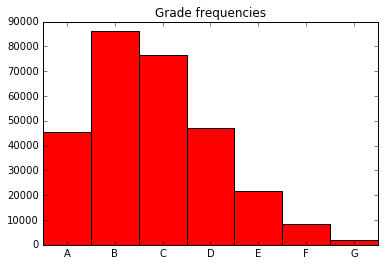

In [99]:
# Plot the distribution of counts of different grades
frequencies = []
counts = df.grade.value_counts()
keys = list(dict(counts).keys())
keys.sort()
for each in keys:
    frequencies.append(dict(counts).get(each))

pos = np.arange(len(keys))
width = 1.0     # gives histogram aspect to the bar diagram


ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(keys)

plt.bar(pos, frequencies, width, color='r')
plt.title('Grade frequencies')


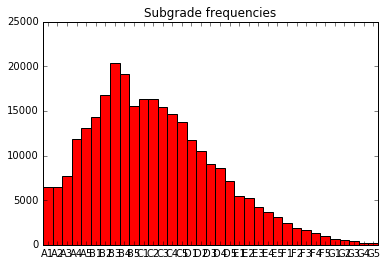

In [100]:
# Plot the distribution of counts of different subgrades

frequencies = []
counts = df.subgrade.value_counts()
keys = list(dict(counts).keys())
keys.sort()
for each in keys:
    frequencies.append(dict(counts).get(each))

pos = np.arange(len(keys))
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(keys)

plt.bar(pos, frequencies, width, color='r')
plt.title('Subgrade frequencies')
plt.show()

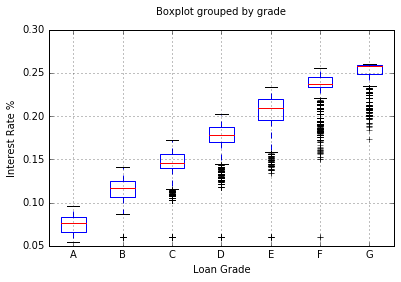

In [101]:
# Box plot of interest rate by different grades

plt.figure()

p = df.boxplot('int_rate','grade')

q0 = p.set_xlabel('Loan Grade')
q1 = p.set_ylabel('Interest Rate %')
q2 = p.set_title('                          ')
plt.show()

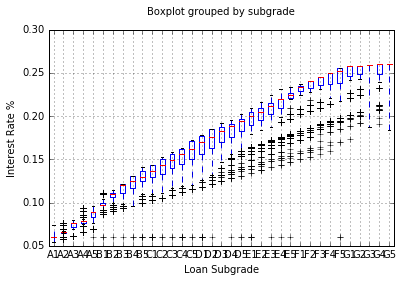

In [102]:
# Box plot of interest rate by different subgrades

plt.figure(figsize=(3,4))

p = df.boxplot('int_rate','subgrade')

q0 = p.set_xlabel('Loan Subgrade')
q1 = p.set_ylabel('Interest Rate %')
q2 = p.set_title('                          ')
plt.show()

2  We confirm the grade and subgrade exhibits similar distribution and influence, therefore we remove one of them to remove collinearity.

In [103]:
df.drop(['subgrade'], axis=1, inplace=True)

### Convert Issue date column type
1. issue_d is currently an object dtype however we don't want to convert it to a date, rather a scalar to describe the length of time( in /year unit) since the first day of the year 2016, since all the loans were issued in the year of 2016. 

In [104]:
from datetime import datetime
# Read the column in the correct format
temp = pd.to_datetime(df['issue_d'],format = '%b-%d')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/1900', date_format)

d = np.zeros(len(temp))
for i in range(len(temp)):
    try:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'D').astype(int))/365)
        #break
    except:
        d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'M').astype(int))/12)

df['issue_d'] = d

2 Converted issue_d showing the length of time( in /year unit) since the first day of the year 2016,

In [105]:
df['issue_d'].head(3)

0    0.602740
1    0.347945
2    0.616438
Name: issue_d, dtype: float64

### Annual income outlier examination
1. Let's examine if any outliers due to typos or other reasons of annual income existing in our data, if a borrower's annual income as claimed is millions per year but request to borrow a loan of several thousands, it would be suspicious record and may need to be drop that record
2. From the statistics below, we see the maximum claimed annual income is $7.5 millions,which is certainly possible, 
highly implausible for a person seeking a loan of a few 10's of K dollars, i.e. implausible in this context.

In [106]:
df['annual_inc'].describe()

count     287238.000000
mean       73151.464096
std        56189.665971
min         3000.000000
25%        45000.000000
50%        63000.000000
75%        88078.750000
max      7500000.000000
Name: annual_inc, dtype: float64

In [107]:
df['loan_amt'].describe()

count    338989.000000
mean      14276.968353
std        8252.264104
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amt, dtype: float64

3 We found the borrowers who claim make more than 1 million a year requested loan amount up to 35k only, and many of the employment title like technician raises suspiciousness about the claim of income over 1 million.

In [108]:
# Examine the information of borrowers who annual income is more than 1 million
df[df['annual_inc'] > 1000000]

,int_rate,loan_amt,funded_amt,funded_amt_inv,term,grade,emp_title,emp_length,home_ownership,annual_inc,...,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec,revol_bal,revol_util,total_cr_line,init_list_status
626,0.1229,8450,8450,3747,36,C,at&t wireless,< 1 year,RENT,2039784,...,Aug-04,1,0,0,7,0,8747,51.80%,11,f
4964,0.0774,6600,6600,6600,36,A,Lockheed Martin,9 years,MORTGAGE,1362000,...,Nov-96,2,NaN,NaN,13,0,20,0.10%,36,f
5225,0.0740,6400,6400,6300,36,A,Hewlett Packard,7 years,MORTGAGE,1440000,...,Dec-95,0,39,NaN,6,0,2926,13%,38,f
8902,0.1062,25000,15500,11430,60,B,Lea Regional Hospital/Pecos Valley,3 years,MORTGAGE,3900000,...,Sep-99,3,NaN,NaN,12,0,3270,10.20%,32,f
9386,0.0788,4500,4500,4500,60,A,St. John Lutheran Church,8 years,MORTGAGE,1080000,...,Nov-83,0,31,NaN,7,0,46337,1.90%,20,f
10660,0.1361,5600,5600,5600,60,C,Dept of army,10+ years,MORTGAGE,1176000,...,Mar-97,0,4,NaN,6,0,11753,73.50%,25,f
11831,0.0751,12000,12000,12000,36,A,TelSource Corp,1 year,MORTGAGE,1200000,...,Oct-89,2,NaN,NaN,12,0,26684,51.90%,26,f
13568,0.1520,25000,25000,24493,60,D,Avis Budget Group,10+ years,RENT,1200000,...,Aug-98,1,NaN,NaN,4,0,11168,69.80%,12,f
14096,0.0617,1500,1500,1500,36,A,Montgomery ISD,5 years,MORTGAGE,1900000,...,Jun-81,2,NaN,NaN,17,0,17396,59.60%,36,f
15948,0.0654,10000,10000,9500,36,A,Convent of the Sacred Heart,10+ years,OWN,1200000,...,Jun-94,0,NaN,NaN,6,0,75706,49.10%,13,f


In [109]:
# Remove the rows where annual income claim is larger than 1 million
df = df[df['annual_inc'] <= 1000000]
# Reset index, this is critical
df = df.reset_index(drop=True)

### Examine Employment title and remove
emp_title is a free text field. Let's examine how many unique values exist:

In [110]:
print (df.emp_title.value_counts().head())
print (df.emp_title.value_counts().tail())
df.emp_title.unique().shape

Teacher             3052
Manager             2469
Registered Nurse    1295
RN                  1230
Supervisor          1085
Name: emp_title, dtype: int64
Century Pools                      1
Longhill Grove Apartments          1
Dillon Boiler Services o., Inc.    1
Specialty Healthcare               1
mailprocessor                      1
Name: emp_title, dtype: int64


(141930,)

There were 141930 unique entries among 338989 observations.It shows some suspiciously specific titles such as EvaluMed/c.t. tech aid. This predictor won't be meaningful and any relationship we might observe might be due to confounding relationships with other predictors like income, employment length.

In [111]:
df.drop(['emp_title'],1, inplace=True)

### Convert data type of column Employment length
emp_length may or may not be confounding with other predictors like income( a 2 year director may make more income than a 10 year tech aid), we can convert this column to int type and leave it for now, and we will examine further pair-wise correlation among predictors to determine if we remove it or not.

In [112]:
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)

### Examine Verification Status
VERIFIED - income and VERIFIED - income source could potentially be the same criteria.For now we'll trust that these are indeed different methods 

In [113]:
df.verification_status.value_counts()

VERIFIED - income           107659
not verified                 91560
VERIFIED - income source     87982
Name: verification_status, dtype: int64

### Purpose loan category and loan title
1. Loan purpose is self filled by borrower and we can use natural language processing technique to extract useful n-grams words and cluster them into different subgroups using unsupervised learning techniques, to keep this project not too sophisticated, for now we will drop this column 
2. Examing the loan category unique counts show they are state farm selected options.
3. Examing the loan title unique counts show they are free text fields and we can drop this column.

In [114]:
df.drop(['purpose'],1, inplace=True)
print('loan category unique counts:')
print (df.loan_cat.value_counts())
print('\nloan title unique counts:')
print (df.loan_title.value_counts())

loan category unique counts:
debt_consolidation    167858
credit_card            64161
home_improvement       16686
other                  14533
major_purchase          6180
small_business          4528
car                     3473
medical                 2814
moving                  1809
wedding                 1637
vacation                1571
house                   1483
educational              247
renewable_energy         221
Name: loan_cat, dtype: int64

loan title unique counts:
Debt consolidation                          89487
Credit card refinancing                     34295
Debt Consolidation                          11206
Home improvement                             8428
Other                                        6912
Consolidation                                3804
debt consolidation                           3483
Debt Consolidation Loan                      2751
Major purchase                               2556
Business                                     2029
Credit Ca

In [115]:
df.drop(['loan_title'],1, inplace=True)


let's keep moving to the next slice of data

In [116]:
df.ix[:5,13:22]

,state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_deliq,mths_since_last_record,num_opencr_line,num_der_rec
0,CA,19.48,0,Feb-94,0,NaN,NaN,10,0
1,NY,14.29,0,Oct-00,0,NaN,NaN,7,0
2,NY,10.50,0,Jun-00,0,41,NaN,10,0
3,TX,5.47,0,Jan-85,0,64,NaN,5,0
4,CT,11.63,0,Dec-96,1,58,NaN,14,0
5,RI,2.05,0,Apr-94,0,26,NaN,6,0


In [117]:
df.drop(['zip_code'],1, inplace=True)

### Delinquency skewed distribution
Examine the distribution of delinquency, it shows it is a right skewed distribution and may need apply box-cox transformation in some cases before modelling depending on what model is used.

In [118]:
df.delinq_2yrs.value_counts()

0     237460
1      33762
2       9643
3       3368
4       1405
5        720
6        373
7        202
8         95
9         56
10        43
11        21
12        20
13         9
16         5
14         4
18         4
17         3
15         2
19         2
24         1
21         1
22         1
29         1
Name: delinq_2yrs, dtype: int64

### Earliest Credit Line type conversion
We will convert this column from object type to a scalar to describe the length of time since the first line of credit. 

In [119]:
from datetime import datetime
# Read the column in the correct format
t = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y')

date_format = "%m/%d/%Y"
dttoday = datetime.strptime('1/1/2017', date_format)

d = np.zeros(len(t))
for i in range(len(t)):
    try:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
        #break
    except:
        d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

d[d<0] = d[d<0] + 100

df['earliest_cr_line'] = d

We move to the last slice of the predictors

In [120]:
df.ix[:5,21:]

,revol_bal,revol_util,total_cr_line,init_list_status
0,28854,52.10%,42,f
1,33623,76.70%,7,f
2,19878,66.30%,17,f
3,2584,40.40%,31,f
4,3511,25.60%,40,f
5,3874,90.10%,25,f


### Convert data type of column Revolving utility
Remove the % sign and convert it to float type

In [121]:
df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

### Remove highly correlated data
Examine correlation matrix and remove highly correlated data to address multicollinearity

In [122]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amt             loan_amt           0.998292
funded_amt_inv         loan_amt           0.994128
                       funded_amt         0.996181
mths_since_last_deliq  delinq_2yrs       -0.575830
total_cr_line          num_opencr_line    0.677215
dtype: float64

In [123]:
df.drop(['funded_amt','funded_amt_inv','mths_since_last_deliq', 'total_cr_line'], axis=1, inplace=True)

### Additional Data Preprocessing for Ordinary Linear Regession Model
### Create dummy variables to encode categorical variables
So far our the data frame df is ready to be used by any recursive partitioning model which will be the first machine learning model I use, and to prepare the data for other models like OLS, additional steps need to be completed such as creating dummy variables to encode categorical columns.

In [124]:
################################
## Categorical predictors one hot encoding ###
################################
df2 = df.copy()

## Create dummy variables for linear regression
df2 = pd.get_dummies(df2)

## Drop NaN values, another option is to impute
df2 = df2.dropna()
# reset index
df2 = df2.reset_index(drop=True)

### Remove highly correlated data of categorical dummy variables
Examine correlation matrix again after dummy variables have been created and remove highly correlated data to address multicollinearity

In [125]:
cor = df2.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

home_ownership_RENT                           home_ownership_MORTGAGE                 -0.628416
verification_status_VERIFIED - income source  verification_status_VERIFIED - income   -0.589650
loan_cat_debt_consolidation                   loan_cat_credit_card                    -0.615399
init_list_status_w                            init_list_status_f                      -1.000000
dtype: float64

In [126]:
df2.drop(['home_ownership_RENT', 'verification_status_VERIFIED - income source',
         'loan_cat_debt_consolidation','init_list_status_w'], axis=1, inplace=True)

## STEP 2 Build Models
## MODEL1 : Gradient Boosting Regression
###  Gradient Boosting for regression Introduction
GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

###  Parameters Tuning and Loss Function 
1. The loss function here we specify as mean_squared_error
2. A set of testing parameters are defined and Gradient Search is used to find the parameters setting that return the smallest loss
3. The returned loss values are reported in a mean +/- std way using 5 cross validation
4. 75% samples are used for training, and 25% are used for validation(testing)

In [2]:
import time
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, make_scorer
from matplotlib import pyplot as plt
from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]
              }

#training file is huge so using non-repeated 5 cv is sufficient
est = GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')

# Create an acceptable formula for our machine learning algorithms
formula_ml = 'int_rate ~ loan_amt '
for i in range(2,len(df.columns)):
    
    if str(df.dtypes[i]) == 'object': 
        formula_ml = formula_ml + ' + ' + 'C(' + df.columns[i] + ')'
    elif (str(df.dtypes[i]) == 'float64') | (str(df.dtypes[i]) == 'float32'):
        formula_ml = formula_ml + ' + ' + df.columns[i]
        
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y1, x1 = dmatrices(formula_ml, data=df, return_type='dataframe')
y1 = np.asarray(y1).ravel()

# For prototype build, only use a tiny portion to test to save time
testet = int(x1.shape[0] * 0.05)
x1,y1 =  x1[:testet], y1[:testet]

## Split data for testing and training
offset = int(x1.shape[0] * 0.75)
X_train1, y_train1 = x1[:offset], y1[:offset]
X_test1, y_test1 = x1[offset:], y1[offset:]


start = time.clock()

#instantiate and fit our model
est.fit(X_train1, y_train1)

best_params = est.best_params_



# Tuning parameter phase

print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()    



Best parameters set found on development set:

{'min_samples_leaf': 5, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 6}

It has the best score of -0.000120

Grid scores on development set:

-0.000122 (+/-0.000130) for {'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 1.0}

-0.000122 (+/-0.000128) for {'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 1.0}

-0.000124 (+/-0.000129) for {'min_samples_leaf': 9, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 4}

-0.000127 (+/-0.000125) for {'min_samples_leaf': 17, 'max_features': 1.0, 'learning_rate': 0.1, 'max_depth': 4}

-0.000120 (+/-0.000121) for {'min_samples_leaf': 3, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 0.3}

-0.000124 (+/-0.000120) for {'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.1, 'max_features': 0.3}

-0.000125 (+/-0.000120) for {'min_samples_leaf': 9, 'max_features': 0.3, 'learning_rate': 0.1, 'max_depth': 4}

-0.000123 (+/-0

### Model evaluation using tuned parameter set
1. Return the squared mean_squared_error of the GSD model applied on test(validation) data set
2. Plot the RMSE reduction rate by the number of estimators and find that the number of estimators approach to 200, the plot reduction of RMSE becomes flat
3. Sort and rank the top 20 influenced predictors 

RMSE: 0.0119


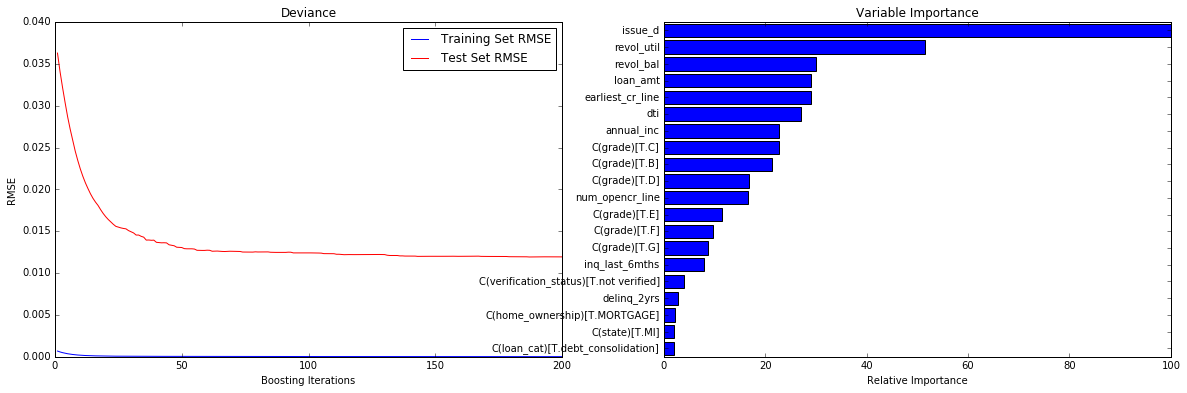

In [3]:
## Evaluate model using tuned parameter
# Fit G boosting model using the tuned selected parameter set
clf = ensemble.GradientBoostingRegressor(n_estimators=200,**est.best_params_)

clf.fit(X_train1, y_train1)
rmse = mean_squared_error(y_test1, clf.predict(X_test1))**0.5
print("RMSE: %.4f" % rmse)

params['n_estimators'] = 200

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test1)):
    test_score[i] = mean_squared_error(y_test1, y_pred)**0.5
    #test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set RMSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set RMSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x1.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Model evaluation using tuned parameter set
1. Return the squared mean_squared_error of the GSD model applied on test(validation) data set
2. Plot the RMSE reduction rate by the number of estimators and find that the number of estimators approach to 200, the plot reduction of RMSE becomes flat
3. Sort and rank the top 20 influenced predictors 

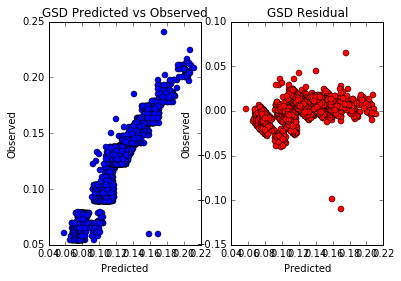

In [47]:
plt.subplot(121) 
plt.plot(clf.predict(X_test1),y_test1,'bo')
plt.title("GSD Predicted vs Observed")
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.subplot(122) 
plt.plot(clf.predict(X_test1),y_test1 - clf.predict(X_test1),'ro')
plt.title("GSD Residual")
plt.xlabel('Predicted')
plt.ylabel('Observed')

## MODEL2 : Regularized Ordinary Linear Regression
### Ordinary Linear Regression Introduction
LinearRegression fits a linear model with coefficients w = (w_1, ..., w_p) to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation. 
### Regularization Introduction
Regularization is a technique used in an attempt to solve the overfitting problem in statistical models and in this project regularization is given by the l2-Ridge and l1 Lasso are evaluated, compared and selected the one with the lowest AIC.

### Extract predictors and response data

In [127]:
from sklearn.utils import shuffle

# Create response vector y and flattern it
y = df2.int_rate.values
y = np.asarray(y).ravel()

# Create a copy of df
df2.drop('int_rate',axis = 1, inplace=True)

# Randomly shuffle 
x, y = shuffle(df2.values, y, random_state=30)

### Centering and scaling predictors
Centering and scaling predictors assures the intercept term is interpreted as the expected value of YiYi when the predictor values are set to their means and it avoids the situation where one variable has a very large scale and influence the RMSE largely.


In [129]:
## Centering and scaling data
from sklearn import preprocessing
x = preprocessing.scale(x)

### Split training and test data sets

In [130]:
## Split data for testing and training
offset = int(x.shape[0] * 0.75)
X_train, y_train = x[:offset], y[:offset]
X_test, y_test = x[offset:], y[offset:]

### Lasso Regularized Ordinary Linear Regression
###  Parameters Tuning and Loss Function 
1. The loss function here we specify as mean_squared_error
2. A set of testing parameters are defined and Gradient Search is used to find the parameters setting that return the smallest loss
3. The returned loss values are reported in a mean +/- std way using 5 cross validation
4. 75% samples are used for training, and 25% are used for validation(testing)
5. Least angle regression with BIC/AIC criterion is used to visually help locate the Alpha parameter that returns the lowest AIC/BIC

Best parameters set found on development set:

{'alpha': 0.0001}

It has the best score of -0.000313

Grid scores on development set:

-0.001478 (+/-0.000100) for {'alpha': 0.1}

-0.000857 (+/-0.000073) for {'alpha': 0.01}

-0.000327 (+/-0.000016) for {'alpha': 0.001}

-0.000313 (+/-0.000016) for {'alpha': 0.0001}

-0.000314 (+/-0.000017) for {'alpha': 1e-05}



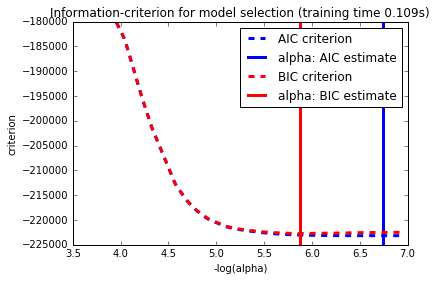

In [131]:
################################
        ## Lasso OLS ###
################################
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Alpha parameters to be tuned
param_grid = {'alpha': [0.1,0.01,0.001,0.0001, 0.00001],
              }
# Grid searching lasso regulated regression, using mean_squared_error as the scoring method
est = GridSearchCV(linear_model.Lasso(),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')
est.fit(X_train, y_train)

# Tuning parameter phase
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()    
 

import time

import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC



##############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X_train, y_train)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

plt.show()

### Lasso Model evaluation using tuned parameter set
1. Return the squared mean_squared_error of the Lasso OLS model applied on test(validation) data set

In [132]:
# Build lasso model using the best params set
lasso = linear_model.Lasso(**est.best_params_)

lasso.fit(X_train, y_train)
rmse = mean_squared_error(y_test, lasso.predict(X_test))**0.5
print("RMSE of using Lasso regulated OLS is: %.6f" % rmse)

RMSE of using Lasso regulated OLS is: 0.017785


### Ridge Ordinary Linear Regression
###  Parameters Tuning and Loss Function 
1. The loss function here we specify as mean_squared_error
2. A set of testing parameters are defined and Gradient Search is used to find the parameters setting that return the smallest loss
3. The returned loss values are reported in a mean +/- std way using 5 cross validation
4. 75% samples are used for training, and 25% are used for validation(testing)


In [133]:
################################
        ## Ridge OLS ###
################################
param_grid = {'alpha': [1,0.5,0.2,0.1, 0.05, 0.02, 0.01],
              }
# http://scikit-learn.org/stable/modules/linear_model.html using Ridge
est = GridSearchCV(linear_model.Ridge(),
                   param_grid, n_jobs=4, refit=True, cv = 5,scoring='mean_squared_error')
est.fit(X_train, y_train)

# Tuning parameter phase
print("Best parameters set found on development set:")
print()
print(est.best_params_)
print()
print("It has the best score of %f" %est.best_score_ )
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in est.grid_scores_:
    print("%0.6f (+/-%0.06f) for %r"
            % (mean_score, scores.std() * 2, params))
    print()   
    
    
# Build ridge model using the best params set
ridge = linear_model.Ridge(**est.best_params_)

ridge.fit(X_train, y_train)
rmse = mean_squared_error(y_test, ridge.predict(X_test))**0.5
print("RMSE of using Ridge regulated OLS is: %.6f" % rmse)


Best parameters set found on development set:

{'alpha': 1}

It has the best score of -0.000314

Grid scores on development set:

-0.000314 (+/-0.000017) for {'alpha': 1}

-0.000314 (+/-0.000017) for {'alpha': 0.5}

-0.000314 (+/-0.000017) for {'alpha': 0.2}

-0.000314 (+/-0.000017) for {'alpha': 0.1}

-0.000314 (+/-0.000017) for {'alpha': 0.05}

-0.000314 (+/-0.000017) for {'alpha': 0.02}

-0.000314 (+/-0.000017) for {'alpha': 0.01}

RMSE of using Ridge regulated OLS is: 0.017783


### Predicted vs Observed and Residuals Plot Examination
1. Predicted vs Observed dots were nicely scattered around the 45 degree angle line, while when predicted interest rate is around 0.15 the observed interest rate can range from 0.05 t0 0.25.
2. Residuals appear to be randomly scattered about 0 respect to the predicted values, while when predicted interest rate is around 0.15 there residuals can range from 0.15 to -.01.

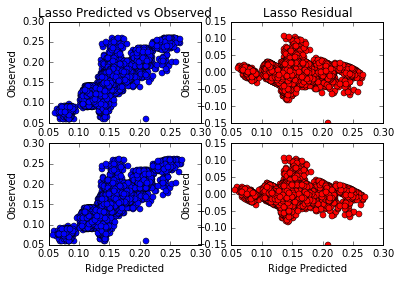

In [134]:
#lasso.fit(X_train, y_train)
plt.subplot(221) 
plt.plot(lasso.predict(X_test),y_test,'bo')
plt.title("Lasso Predicted vs Observed")
plt.xlabel('Predicted')
plt.ylabel('Observed')


plt.subplot(222) 
plt.plot(lasso.predict(X_test),y_test - lasso.predict(X_test),'ro')
plt.title("Lasso Residual")
plt.xlabel('Predicted')
plt.ylabel('Observed')

#lasso.fit(X_train, y_train)
plt.subplot(223) 
plt.plot(ridge.predict(X_test),y_test,'bo')
plt.xlabel('Ridge Predicted')
plt.ylabel('Observed')


plt.subplot(224) 
plt.plot(ridge.predict(X_test),y_test - lasso.predict(X_test),'ro')
plt.xlabel('Ridge Predicted')
plt.ylabel('Observed')


###  Model select between Ridge and Lasso
1. Bootstrap
2. T test to rmse difference 
3. AIC 
4. Pick Lasso Model

In [136]:
################################
## Model select between Ridge and Lasso ###
################################

## Bootstrap sampling index preparation
from sklearn import cross_validation
bs = cross_validation.ShuffleSplit(len(x), n_iter=3, test_size=.25, random_state=0)

# Bootstrap Cross validation
r_rmse = []
l_rmse = []
for train_index, test_index in bs:
    print("TRAIN:", train_index, "TEST:", test_index)
    print()
    ridge.fit(x[train_index], y[train_index])
    rmse = mean_squared_error(y[test_index], ridge.predict(x[test_index]))**0.5
    r_rmse.append(rmse)
    print("RMSE of using Ridge regulated OLS is: %.6f" % rmse)
    print()
    lasso.fit(x[train_index], y[train_index])
    rmse = mean_squared_error(y[test_index], lasso.predict(x[test_index]))**0.5
    l_rmse.append(rmse)
    print("RMSE of using Lasso regulated OLS is: %.6f" % rmse)

## t test statistical difference of performance
from scipy.stats import ttest_ind

# Use scipy.stats.ttest_ind.
t, p = ttest_ind (l_rmse, r_rmse, equal_var=False)
print ("ttest_ind: t = %g  p = %g" % (t, p))

alpha = 0.5
if (t >0) & (p/2 < alpha): 
    print("We reject the null hypothesis and believe Lasso's rmse is greater than Ridge's mse since when p/2 < alpha and t > 0")
elif (t <0) & (p/2 < alpha): 
    print("We reject the null hypothesis and believe Lasso's rmse is not greater than Ridge's mse since when p/2 < alpha and t < 0")

import math
print("the ACI of Lasso is:", math.log(np.mean(l_rmse)**2)*len(y[test_index]) + 2*len(df.columns))
print("the ACI of Ridge is:",math.log(np.mean(r_rmse)**2)*len(y[test_index]) + 2*len(df.columns))

TRAIN: [26465 27849 34195 ..., 30403 21243  2732] TEST: [16333 14662 10594 ...,  5759  1385 26642]

RMSE of using Ridge regulated OLS is: 0.017828

RMSE of using Lasso regulated OLS is: 0.017848
TRAIN: [16506  5930 21530 ..., 12573 30462  1772] TEST: [11666  9653 12043 ..., 24510 21761  3655]

RMSE of using Ridge regulated OLS is: 0.017683

RMSE of using Lasso regulated OLS is: 0.017683
TRAIN: [12652 31720 16909 ..., 22147 16835 21790] TEST: [  935 33232 29449 ..., 22098 25449  2829]

RMSE of using Ridge regulated OLS is: 0.017745

RMSE of using Lasso regulated OLS is: 0.017759
ttest_ind: t = 0.180368  p = 0.865773
We reject the null hypothesis and believe Lasso's rmse is greater than Ridge's mse since when p/2 < alpha and t > 0
the ACI of Lasso is: -74258.27322750623
the ACI of Ridge is: -74270.14265689989


### Plot feature importance for Lasso OLS

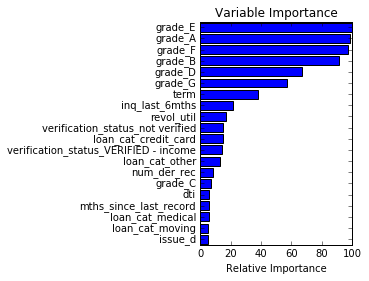

In [137]:
###############################################################################
# Plot feature importance for Lasso OLS

coeff = list(lasso.coef_)
indices = [i for i, x in enumerate(coeff) if x != 0]

coe_importance = lasso.coef_
coe_importance = abs(coe_importance)
#coe_importance = sorted(coe_importance,reverse=True)
# make importances relative to max importance

coe_importance = 100.0 * (coe_importance / coe_importance.max())
sorted_idx = np.argsort(abs(coe_importance))[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, coe_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df2.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Gradient Boosting Regressor vs Lasso OLR Perforamnce Comparison

In [163]:
# Create an acceptable formula for our machine learning algorithms
formula_ml = 'int_rate ~ loan_amt '
for i in range(2,len(df.columns)):
    
    if str(df.dtypes[i]) == 'object': 
        formula_ml = formula_ml + ' + ' + 'C(' + df.columns[i] + ')'
    elif (str(df.dtypes[i]) == 'float64') | (str(df.dtypes[i]) == 'float32'):
        formula_ml = formula_ml + ' + ' + df.columns[i]
        
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y1, x1 = dmatrices(formula_ml, data=df, return_type='dataframe')
y1 = np.asarray(y1).ravel()


## Split data for testing and training
offset = int(x1.shape[0] * 0.75)
X_train1, y_train1 = x1[:offset], y1[:offset]
X_test1, y_test1 = x1[offset:], y1[offset:]

X_train = X_train[:19887]

offset = [100,1000,2500,5000,8000,10000,15000,19877]


GSD_train = []
GSD_predict = []
OLR_train = []
OLR_predict = []
for i in offset:
    X_l = X_train[:i]
    y_l = y_train[:i]
    X_g = X_train1[:i]
    y_g = y_train1[:i]
    
    t1 = time.time()
    clf.fit(X_g, y_g)
    t_bic = time.time() - t1
    GSD_predict.append(t_bic)
    print(t_bic)
    
    t1 = time.time()
    clf.predict(X_g)
    t_bic = time.time() - t1
    GSD_train.append(t_bic)
    print(t_bic)

    t1 = time.time()
    lasso.fit(X_l, y_l)
    t_bic = time.time() - t1
    OLR_train.append(t_bic)
    print(t_bic)
    
    t1 = time.time()
    lasso.predict(X_l)
    t_bic = time.time() - t1
    OLR_predict.append(t_bic)
    print(t_bic)
    
GSD_predict = np.array(GSD_predict)
GSD_train = np.array(GSD_train)
OLR_predict = np.array(OLR_predict)
OLR_train = np.array(OLR_train)

   
    

offset = [100,1000,2500,5000,8000,10000,15000,19877]

GSD_rmse = []

OLR_rmse = []
for i in offset:
    X_l = X_train[:i]
    y_l = y_train[:i]
    X_g = X_train1[:i]
    y_g = y_train1[:i]
    
    clf.fit(X_g, y_g)
    rmse = mean_squared_error(y_test1, clf.predict(X_test1))**0.5
    GSD_rmse.append(rmse)
    print(rmse)

    lasso.fit(X_l, y_l)
    rmse2 = mean_squared_error(y_test, lasso.predict(X_test))**0.5
    OLR_rmse.append(rmse2)
    print(rmse2)

### Plot the comparisons

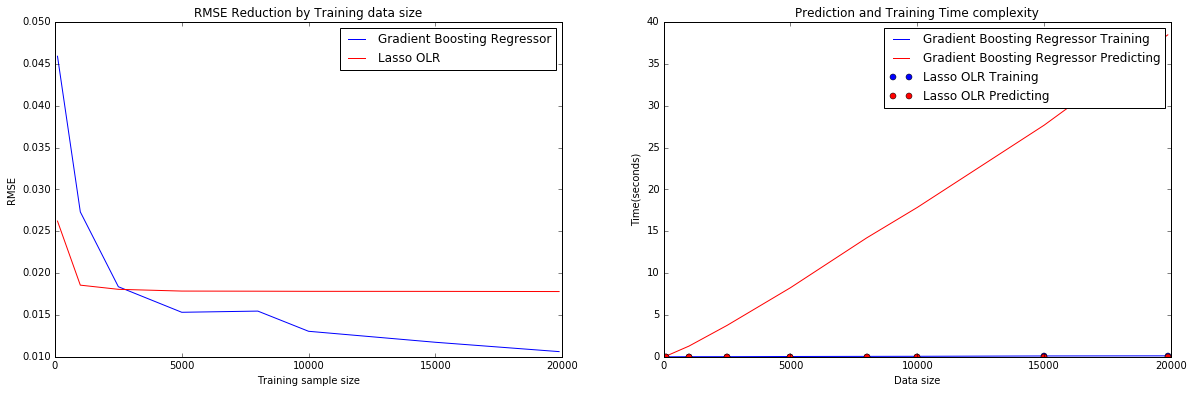

In [203]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('RMSE Reduction by Training data size')
plt.plot(offset, GSD_rmse, 'b-',
         label='Gradient Boosting Regressor')
plt.plot(offset, OLR_rmse, 'r-',
         label='Lasso OLR')
plt.legend(loc='upper right')
plt.xlabel('Training sample size')
plt.ylabel('RMSE')

###############################################################################

plt.subplot(1, 2, 2)
plt.title('Prediction and Training Time complexity')
plt.plot(offset, GSD_train, 'b-',
         label='Gradient Boosting Regressor Training')
plt.plot(offset, GSD_predict, 'r-',
         label='Gradient Boosting Regressor Predicting')
plt.plot(offset, OLR_train, 'bo',
         label='Lasso OLR Training')
plt.plot(offset, OLR_predict, 'ro',
         label='Lasso OLR Predicting')
plt.legend(loc='upper right')
plt.xlabel('Data size')
plt.ylabel('Time(seconds)')
plt.show()

## STEP 3 Test Modesl with hold out for testing files

### Read the testing data into data frame

In [138]:
# Read the training.csv into data frame df
td = pd.read_csv("Holdout for Testing.csv", infer_datetime_format=True,low_memory=False)

# Name the data frame with the columnNames
td.columns = columnNames

### Function to preprocess testing data for Gradient Boosting Model

In [139]:

def dataPreprocessGSD(df):
    
        
        # reset index
        df = df.reset_index(drop=True)

        D = decimal.Decimal
        # Pandas can not store NaN in int type column, thus had remove all NaNs
        for col in ('loan_amt','funded_amt','funded_amt_inv','term'):
            df[col] = df[col].str.replace(r'[^-+\d.]', '').astype(D)
            df[col] = df[col].astype('int')

        df = df.reset_index(drop=True)

        df.drop(['id_loan','id_borrower'],1, inplace=True)

        from datetime import datetime
        # Read the column in the correct format
        temp = pd.to_datetime(df['issue_d'],format = '%m/%d/%Y')

        date_format = "%m/%d/%Y"
        dttoday = datetime.strptime('1/1/1900', date_format)

        d = np.zeros(len(temp))
        for i in range(len(temp)):
            try:
                d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'D').astype(int))/365)
                #break
            except:
                d[i] = ((np.timedelta64(temp[i] - pd.Timestamp(dttoday),'M').astype(int))/12)

        df['issue_d'] = d

        df.drop(['emp_title'],1, inplace=True)

        df.replace('n/a', np.nan,inplace=True)
        df.emp_length.fillna(value=0,inplace=True)
        df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
        df['emp_length'] = df['emp_length'].astype(int)

        df.drop(['purpose'],1, inplace=True)
        df.drop(['loan_title'],1, inplace=True)
        df.drop(['zip_code'],1, inplace=True)

        from datetime import datetime
        # Read the column in the correct format
        t = pd.to_datetime(df['earliest_cr_line'],format = '%m/%d/%Y')

        date_format = "%m/%d/%Y"
        dttoday = datetime.strptime('1/1/2017', date_format)

        d = np.zeros(len(t))
        for i in range(len(t)):
            try:
                d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'D').astype(int))/-365)
                #break
            except:
                d[i] = ((np.timedelta64(t[i] - pd.Timestamp(dttoday),'M').astype(int))/-12)

        d[d<0] = d[d<0] + 100

        df['earliest_cr_line'] = d

        df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

        df.drop(['funded_amt','funded_amt_inv','mths_since_last_record', 'total_cr_line','subgrade'], axis=1, inplace=True)

        df.drop(['mths_since_last_deliq'], axis=1, inplace=True)

        return df

In [140]:
# Preprocess the testing data
td = dataPreprocessGSD(td)
td.fillna(0, inplace=True)

### Function to form the dmatrices for Gradient Boosting Model

In [143]:
# Create an acceptable formula for our machine learning algorithms
def formGSDEq(df):
    
    formula_ml = 'int_rate ~ loan_amt  + C(grade) + C(home_ownership) + annual_inc + C(verification_status) + issue_d + C(loan_cat) + C(state) + dti + earliest_cr_line + revol_util + C(init_list_status)'

    # Create the random forest model and fit the model to our training data
    y1, x1 = dmatrices(formula_ml, data=df, return_type='dataframe')
    
    return x1

In [48]:
# Form the dmatrices and fill the missing columns not in testing data but in the training data set
xx = formGSDEq(td)
xx.insert(7, 'C(home_ownership)[T.MORTGAGE]', 0)
xx.insert(8, 'C(home_ownership)[T.NONE]', 0)
xx.insert(9, 'C(home_ownership)[T.OTHER]', 0)
xx.insert(16, 'C(loan_cat)[T.educational]', 0)
xx.insert(38, 'C(state)[T.IA]', 0)
xx.insert(39, 'C(state)[T.ID]', 0)
xx.insert(47, 'C(state)[T.ME]', 0)
xx.insert(54, 'C(state)[T.NE]', 0)
xx.insert(81, 'delinq_2yrs', 0)
xx.insert(83, 'inq_last_6mths', 0)
xx.insert(84, 'num_opencr_line', 0)
xx.insert(85, 'num_der_rec', 0)
xx.insert(86, 'revol_bal', 0)

### Predict the interest rate using Gradient Boosting and save into a temp csv file t1.csv

In [84]:
result = clf.predict(xx)

In [151]:
np.savetxt("t1.csv", result, delimiter=",")

### Function to preprocess testing data for Ordinary Linear Regression use

In [147]:
def dataPreprocessOLR(df):

    df2 = df.copy()

    ## Create dummy variables for linear regression
    df2 = pd.get_dummies(df2)

    # Create a copy of df
    df2.drop('int_rate',axis = 1, inplace=True)
    
    df2.drop(['home_ownership_RENT', 'verification_status_VERIFIED - income source',
         'loan_cat_debt_consolidation','init_list_status_w'], axis=1, inplace=True)
    
    return df2

In [148]:
# Form the dmatrices and fill the missing columns not in testing data but in the training data set
td2 = dataPreprocessOLR(td)
td2.insert(9, 'mths_since_last_record', 0)
td2.insert(21, 'home_ownership_ANY', 0)
td2.insert(23, 'home_ownership_NONE', 0)
td2.insert(24, 'home_ownership_OTHER', 0)
td2.insert(30, 'loan_cat_educational', 0)
td2.insert(53, 'state_IA', 0)
td2.insert(54, 'state_ID', 0)
td2.insert(62, 'state_ME', 0)
td2.insert(69, 'state_NE', 0)

### Predict the interest rate using Lasso Regularization and save the results to csv

In [150]:
x = td2.values
x = preprocessing.scale(x)
result2 = lasso.predict(x)

In [152]:
# Merge and combine the two predictions results into one csv
with open('t1.csv') as fin, open('Result from Dingchao Zhang.csv', 'w') as fout:
        index = 0
        for line in iter(fin.readline, ''):
            fout.write(line.replace('\n', ', ' + str(result2[index]) + '\n'))
            index += 1

In [153]:
## Add columns to the predictions results
import csv
with open('Result from Dingchao Zhang.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('Result from Dingchao Zhang.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(['Gradient Boosting Prediction','Lasso OLR Prediction',])
    w.writerows(data)

In [154]:
# Remove the temp t1.csv file
import os
os.remove('t1.csv')